# Title here

Description here

## Table of contents
- [1. Business undestanding](#business)
- [2. Data understanding](#data)
    - [2.1. Gathering data](#gather)
    - [2.2. Assessing data](#assess)
- [3. Prepare data](#prepare)
- [4. Data modeling](#model)
- [5. Evaluate the results](#eval)
- [6. Deploy](#deploy)

<a name="business"></a>
## 1. Business understanding

In this notebook we will try to address the following questions using data from [Stack Overflow Annual Developer Survey](https://insights.stackoverflow.com/survey).

> What are the most popular programming languages over the past five years?\
> What countries have more female respondants?\
> Are male respondants happier than female respondants?\
> What countries have the highest job satisfaction rates?

The following sections serve as a guide in order to understand the data and what needs to be done in order to answer the questions above.

<a name="data"></a>
## 2. Data understanding

We begin our work by downloading the data that we will need in order to address the questions layed out in [Section 1.](#business). We will then proceed to taking a look at our data to get a sense of what needs to be changed later on

<a name="gather"></a>
   

<a name="gather"></a>
### 2.1. Gathering data

First, we need to download all the necessary data. In order to do so, we can run the line below to download all Stack Overflow surveys for all years:

In [ ]:
# Download survey data
%run -i '../download/download.py'

# Download shape files
%run -i '../download/shape.py'

These are all the surveys since 2011. We will only use the ones from the last five years. One of the reasons for doing so is that the structure of the survey changed and similar questions might not be comparable anymore. Next, in preparation for the next sections we can import the relevant libraries.

In [1]:
# Import libraries
import geopandas as gpd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from pycountry import countries
from tqdm.auto import tqdm
%matplotlib inline

<a name="assess"></a>
### 2.2. Assessing data

Now that we have downloaded all the datasets let's start by reading the csvs from the past five years. In doing so, I am ignoring the first column as it serves as an ordered identifier for the respondants.

In [2]:
# Import survey data and skip first column
import warnings; warnings.simplefilter('ignore')
survey_2016 = pd.read_csv("../data/survey/survey_2016.csv").iloc[:, 1:]
survey_2017 = pd.read_csv("../data/survey/survey_2017.csv").iloc[:, 1:]
survey_2018 = pd.read_csv("../data/survey/survey_2018.csv").iloc[:, 1:]
survey_2019 = pd.read_csv("../data/survey/survey_2019.csv").iloc[:, 1:]
survey_2020 = pd.read_csv("../data/survey/survey_2020.csv").iloc[:, 1:]

# Import shapefile with geopandas
map_df = gpd.read_file("../data/shapefile/world_countries_2017.shp")

Great! Now we can quickly look at what these datasets look like. I will do that by picking two random samples from the survey.

In [3]:
# Show dataframe for two random samples for 2020
pd.options.display.max_columns = None # to show all columns
survey_2020.sample(2)

,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
53303,I am a developer by profession,Yes,22.0,18,Monthly,15000.0,25716.0,China,Chinese Yuan Renminbi,CNY,Firebase,MongoDB;MySQL;Redis,"Designer;Developer, front-end;Developer, full-...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,East Asian,Man,Specific department or team I’d be working on;...,Slightly satisfied,"I’m not actively looking, but I am open to new...",Rust;Swift,HTML/CSS;JavaScript,Node.js;React Native;TensorFlow,Node.js,Github,Jira;Github;Gitlab,Yes,Extremely important,Fairly important,Wanting to work with new technologies;Growth o...,"Read company media, such as employee blogs or ...",Every few months,No,Yes,Yes,Sometimes: 1-2 days per month but less than we...,Start a free trial;Ask developers I know/work ...,"Hello, old friend",Stack Overflow (public Q&A for anyone who codes),Play games;Visit Stack Overflow,MacOS,"10,000 or more employees",Linux,MacOS,I have some influence,Straight / Heterosexual,Yes,"Yes, definitely",A few times per week,Daily or almost daily,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",React.js;Vue.js,React.js;Vue.js,Just as welcome now as I felt last year,40.0,4,Less than 1 year
14502,I am a developer by profession,Yes,27.0,16,Monthly,6000.0,77832.0,Germany,European Euro,EUR,NaN,NaN,"Academic researcher;Developer, back-end;Develo...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed full-time,South Asian,Man,"Industry that I’d be working in;Languages, fra...",Very dissatisfied,"I’m not actively looking, but I am open to new...",Assembly;Bash/Shell/PowerShell;C;C++;Python;Rust,Assembly;Bash/Shell/PowerShell;C;C++;Python,NaN,NaN,Confluence;Github;Gitlab,Confluence;Jira;Github;Gitlab,Yes,Somewhat important,Fairly important,Curious about other opportunities;Better compe...,"Read company media, such as employee blogs or ...",Once every few years,No,No,Yes,Rarely: 1-2 days per year or less,NaN,"Hello, old friend",Stack Overflow (public Q&A for anyone who code...,Call a coworker or friend;Visit Stack Overflow...,Windows,"10,000 or more employees",NaN,NaN,I have little or no influence,Straight / Heterosexual,Yes,"Yes, somewhat",Less than once per month or monthly,Daily or almost daily,Neither easy nor difficult,Too long,No,"Another engineering discipline (such as civil,...",NaN,NaN,NaN,NaN,12,5


And for the remaining years we see:

In [4]:
# Random sample for 2019
survey_2019.sample(2)

,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,UnitTests,PurchaseHow,PurchaseWhat,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
31010,I am a developer by profession,Yes,Less than once per year,The quality of OSS and closed source software ...,Employed full-time,Canada,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Another engineering discipline (ex. civil, ele...",Taken an online course in programming or softw...,2-9 employees,"Developer, back-end;Developer, front-end;Devel...",2,18,2,Slightly satisfied,Slightly satisfied,Somewhat confident,Not sure,Not sure,I am not interested in new job opportunities,Less than a year ago,Interview with people in peer roles;Interview ...,No,Opportunities for professional development;How...,I was preparing for a job search,CAD,Canadian dollar,55000.0,Yearly,41986.0,40.0,There's no schedule or spec; I work on what se...,Inadequate access to necessary tools;Non-work ...,A few days each month,Office,A little below average,"Yes, because I see value in code review",2.0,"No, but I think we should",Developers and management have nearly equal in...,I have some influence,C#;HTML/CSS;Java;JavaScript;PHP,C++;JavaScript;Kotlin;TypeScript,Microsoft SQL Server;MySQL;PostgreSQL;Redis;SQ...,Microsoft SQL Server;MySQL;PostgreSQL;Redis;SQ...,NaN,NaN,Express;Laravel;React.js,Express;React.js,Node.js,Node.js,Android Studio;Visual Studio Code,Linux-based,Development;Testing;Production;Outside of work...,Non-currency applications of blockchain,A passing fad,No,Yes,Yes,Facebook,In real life (in person),Username,2015,Multiple times per day,Find answers to specific questions;Learn how t...,More than 10 times per week,Stack Overflow was much faster,31-60 minutes,Yes,I have never participated in Q&A on Stack Over...,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","No, not at all",Just as welcome now as I felt last year,Industry news about technologies you're intere...,28.0,Man,No,Straight / Heterosexual,White or of European descent,Yes,Appropriate in length,Easy
65122,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Independent contractor, freelancer, or self-em...",United States,No,Associate degree,Fine arts or performing arts (ex. graphic desi...,Taken an online course in programming or softw...,NaN,Student,1,30,NaN,NaN,NaN,NaN,NaN,NaN,"I’m not actively looking, but I am open to new...",Less than a year ago,NaN,NaN,Office environment or company culture;How wide...,I was preparing for a job search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TensorFlow,NaN,IPython / Jupyter,MacOS,I do not use containers,NaN,NaN,Yes,Yes,Yes,Facebook,In real life (in person),Username,2016,Daily or almost daily,Find answers to specific questions,6-10 times per week,Stack Overflow was much faster,60+ minutes,Yes,I have never participated in Q&A on Stack Over...,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Tech...,34.0,Man,No,Straig

In [5]:
# Random sample for 2018
survey_2018.sample(2)

,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
17403,Yes,Yes,Brazil,No,Employed part-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Information systems, information technology, o...",10 to 19 employees,Back-end developer;Data or business analyst;Da...,18-20 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82909,Yes,Yes,Bolivia,NaN,NaN,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",NaN,Back-end developer;Data scientist or machine l...,6-8 years,6-8 years,NaN,Extremely satisfied,Working as a founder or co-founder of my own c...,"I’m not actively looking, but I am open to new...",Less than a year ago,10.0,2.0,9.0,4.0,8.0,6.0,3.0,1.0,7.0,5.0,2.0,7.0,5.0,6.0,4.0,3.0,8.0,9.0,11.0,10.0,1.0,1.0,2.0,4.0,3.0,5.0,5.0,2.0,7.0,1.0,3.0,6.0,4.0,My job status or other personal status changed,U.S. dollars ($),720,Monthly,8640.0,USD,NaN,NaN,Participated in a full-time developer training...,The official documentation and/or standards fo...,I already had a full-time job as a developer w...,To improve my general technical skills or prog...,Agree,Agree,Disagree,C#;Java;JavaScript;PHP;SQL;TypeScript;VBA;VB.N...,C;C++;C#;Go;Java;JavaScript;Objective-C;Python...,MongoDB;SQL Server;MySQL,Cassandra;MongoDB;SQL Server;MySQL;PostgreSQL;...,Heroku;Linux;WordPress,Android;Arduino;AWS;Azure;Heroku;Linux;WordPre...,Angular;Node.js;React;Cordova,Angular;.NET Core;Django;Node.js;React;Cordova...,Android Studio;Atom;Eclipse;Visual Studio;Visu...,Windows,2,Agile;Scrum,Git,Less than once per month,I'm not sure/I don't know,NaN,NaN,Neither agree nor disagree,Somewhat agree,Neither agree nor

In [6]:
# Random sample for 2017
survey_2017.sample(2)

,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,YearsCodedJobPast,DeveloperType,WebDeveloperType,MobileDeveloperType,NonDeveloperType,CareerSatisfaction,JobSatisfaction,ExCoderReturn,ExCoderNotForMe,ExCoderBalance,ExCoder10Years,ExCoderBelonged,ExCoderSkills,ExCoderWillNotCode,ExCoderActive,PronounceGIF,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,ImportantBenefits,ClickyKeys,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,CousinEducation,WorkStart,HaveWorkedLanguage,WantWorkLanguage,HaveWorkedFramework,WantWorkFramework,HaveWorkedDatabase,WantWorkDatabase,HaveWorkedPlatform,WantWorkPlatform,IDE,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,MetricAssess,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
5799,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Bachelor's degree,A humanities discipline,Never,10 to 19 employees,Venture-funded startup,2 to 3 years,Less than a year,NaN,Web developer,Front-end Web developer,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"With a hard ""g,"" like ""gift""",Agree,Agree,Somewhat agree,Disagree,Agree,Agree,Somewhat agree,Strongly disagree,Disagree,Somewhat agree,Somewhat agree,Agree,Disagree,Somewhat agree,Agree,Disagree,Agree,"I'm not actively looking, but I am open to new...",NaN,Less than a year ago,Very important,Important,Somewhat important,Important,Somewhat important,Somewhat important,Important,Important,Important,Very important,Not very important,Somewhat important,Important,Important,Somewhat important,Vacation/days off; Health benefits; Expected w...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U.S. dollars ($),Somewhat underpaid,Both,NaN,NaN,NaN,NaN,NaN,10:00 AM,JavaScript; PHP; Ruby,NaN,Node.js; React,Node.js; React,NaN,NaN,Mac OS,NaN,Atom; Sublime Text,Keep the room absolutely quiet,Pair,Git,A few times a week,Agree,Somewhat agree,Somewhat agree,Agree,Agree,Disagree,Somewhat agree,Bugs found; Customer satisfaction; On time/in ...,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,Some influence,Some influence,Some influence,S

In [7]:
# Random sample for 206
survey_2016.sample(2)

,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,occupation_group,experience_range,experience_midpoint,salary_range,salary_midpoint,big_mac_index,tech_do,tech_want,aliens,programming_ability,employment_status,industry,company_size_range,team_size_range,women_on_team,remote,job_satisfaction,job_discovery,dev_environment,commit_frequency,hobby,dogs_vs_cats,desktop_os,unit_testing,rep_range,visit_frequency,why_learn_new_tech,education,open_to_new_job,new_job_value,job_search_annoyance,interview_likelihood,how_to_improve_interview_process,star_wars_vs_star_trek,agree_tech,agree_notice,agree_problemsolving,agree_diversity,agree_adblocker,agree_alcohol,agree_loveboss,agree_nightcode,agree_legacy,agree_mars,important_variety,important_control,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
36487,Meta Stack Overflow Post,United Kingdom,Northern Europe,Western Europe,30-34,32.0,Male,Programmer; Sr. Developer,Developer with a statistics or mathematics bac...,"Mathematics Developers (Data Scientists, Machi...",11+ years,13.0,"$160,000 - $170,000",165000.0,4.22,AngularJS; C#; F#; SQL Server,"Cloud (AWS, GAE, Azure, etc.); F#; Haskell; Rust",No,10.0,Freelance / Contractor,Finance / Banking,"1,000-4,999 employees",10-14 people,0,I rarely work remotely,I'm neither satisfied nor dissatisfied,Contacted by company (in-house recruiter),Emacs; IntelliJ; Visual Studio; Xamarin,Multiple times a day,5-10 hours per week,Cats,Mac OS X,Yes,101 - 500,Once a week,I want to be a better developer,I'm self-taught; Masters Degree in Computer Sc...,I am actively looking for a new job,Tech stack; Work/life balance; Office location...,The interview process,50%,Show me more live code; Show me the space in w...,Star Trek,Agree completely,Agree completely,Agree completely,Agree completely,Agree completely,Agree somewhat,Neutral,Agree somewhat,Agree completely,Neutral,This is somewhat important,This is very important,I don't care about this,This is very important,This is somewhat important,This is somewhat important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,Poor team dynamics; Fragile code base; Poor do...,Beacause I love to learn
9360,Facebook,United States,North America,North America,20-24,22.0,Male,Developer; Engineer; Programmer,NaN,NaN,NaN,NaN,NaN,NaN,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we have a better sense of what the data looks like, so we can proceed to picking the columns that we will need for the analysis, given the questions we outlines in [Section 1.](#business). These are the following:

The columns that indicate what language respondants want to learn are the following:
> Survey 2020: LanguageWorkedWith \
> Survey 2019: LanguageWorkedWith \
> Survey 2018: LanguageWorkedWith \
> Survey 2017: HaveWorkedLanguage \
> Survey 2016: tech_do

The columns that indicate how satisfied a respondant is with their job are:
> Survey 2020: JobSat \
> Survey 2019: JobSat \
> Survey 2018: JobSatisfaction \
> Survey 2017: JobSatisfaction \
> Survey 2016: job_satisfaction

The columns that indicate education status are the following:
> Survey 2020: EdLevel \
> Survey 2019: EdLevel \
> Survey 2018: FormalEducation \
> Survey 2017: FormalEducation \
> Survey 2016: education

The columns that indicate where the respondant lives are:
> Survey 2020: Country \
> Survey 2019: Country \
> Survey 2018: Country \
> Survey 2017: Country \
> Survey 2016: country

The columns that indicate what is the respondant's developer status are:
> Survey 2020: Gender \
> Survey 2019: Gender \
> Survey 2018: Gender \
> Survey 2017: Gender \
> Survey 2016: gender

The columns that indicate what is the respondant's employment status are:
> Survey 2020: Employment \
> Survey 2019: Employment \
> Survey 2018: Employment \
> Survey 2017: EmploymentStatus \
> Survey 2016: employment_status


Lastly, we can take a loop at the shapefiles we imported:

In [8]:
# Head of shapefiles
map_df.head()

,OBJECTID,CNTRY_NAME,CNTRY_CODE,BPL_CODE,geometry
0,1,Algeria,012,13010.0,"MULTIPOLYGON (((-2.05592 35.07370, -2.05675 35..."
1,2,Angola,024,12010.0,"MULTIPOLYGON (((12.79760 -4.41685, 12.79875 -4..."
2,3,In dispute South Sudan/Sudan,9999,99999.0,"POLYGON ((28.08408 9.34722, 28.03889 9.34722, ..."
3,4,Benin,204,15010.0,"MULTIPOLYGON (((1.93753 6.30122, 1.93422 6.299..."
4,5,Botswana,072,14010.0,"POLYGON ((25.16312 -17.77816, 25.16383 -17.778..."


So the countries are in the variable CNTRY_NAME. We will need to match these with our data and for that we will have to harmonize all the country names in [Section 3.](#prepare)

Given all of the above we can proceed to prepare our data!

<a name="prepare"></a>
## 3. Prepare data

Since we already know which columns we will need in order to answer our questions we can first start by droping columns that are not relevant to us:

In [9]:
# Put relevant variables in list
keep_2020 = ['LanguageWorkedWith', 'JobSat', 'EdLevel', 'Country', 'Gender', 'Employment']
keep_2019 = ['LanguageWorkedWith', 'JobSat', 'EdLevel', 'Country', 'Gender', 'Employment']
keep_2018 = ['LanguageWorkedWith', 'JobSatisfaction', 'FormalEducation', 'Country', 'Gender', 'Employment']
keep_2017 = ['HaveWorkedLanguage', 'JobSatisfaction', 'FormalEducation', 'Country', 'Gender', 'EmploymentStatus']
keep_2016 = ['tech_do', 'job_satisfaction', 'education', 'country', 'gender', 'employment_status']

# Keep only relevant variables
survey_2020 = survey_2020[keep_2020]
survey_2019 = survey_2019[keep_2019]
survey_2018 = survey_2018[keep_2018]
survey_2017 = survey_2017[keep_2017]
survey_2016 = survey_2016[keep_2016]

Nice! Now we can rename the columns so that all dataframes have the same names for variables

In [10]:
# Rename columns
survey_2020.rename(columns={'LanguageWorkedWith': 'languages', 'JobSat': 'job_satisfaction', 
                           'EdLevel': 'education', 'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2019.rename(columns={'LanguageWorkedWith': 'languages', 'JobSat': 'job_satisfaction', 
                           'EdLevel': 'education', 'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2018.rename(columns={'LanguageWorkedWith': 'languages', 'JobSatisfaction': 'job_satisfaction', 
                           'FormalEducation': 'education', 'Country': 'country', 'Gender': 'gender', 
                           'Employment': 'employment'}, inplace = True)
survey_2017.rename(columns={'LanguageWorkedWith': 'languages', 'JobSatisfaction': 'job_satisfaction', 
                           'FormalEducation': 'education', 'Country': 'country', 'Gender': 'gender', 
                           'EmploymentStatus': 'employment'}, inplace = True)
survey_2016.rename(columns={'tech_do': 'languages', 'job_satisfaction': 'job_satisfaction', 
                           'education': 'education', 'country': 'country', 'gender': 'gender', 
                           'employment_status': 'employment'}, inplace = True);

Let's now start the pandarallel session in order to be able to use pandas' methods in parallel.

In [11]:
# Initialize pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Now we need to harmonize the answers to different questions for all survey years in order to merge them and have a complete data set. Let's with some an easy one and look at the category for gender in each year.

In [12]:
# Print unique gender categories in 2020
survey_2020['gender'].unique()

array(['Man', nan, 'Woman',
       'Man;Non-binary, genderqueer, or gender non-conforming',
       'Non-binary, genderqueer, or gender non-conforming',
       'Woman;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man'], dtype=object)

In [13]:
# Print unique gender categories in 2019
survey_2019['gender'].unique()

array(['Man', nan, 'Woman',
       'Non-binary, genderqueer, or gender non-conforming',
       'Woman;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man;Non-binary, genderqueer, or gender non-conforming',
       'Woman;Man',
       'Man;Non-binary, genderqueer, or gender non-conforming'],
      dtype=object)

In [14]:
# Print unique gender categories in 2018
survey_2018['gender'].unique()

array(['Male', nan, 'Female',
       'Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Female;Male',
       'Male;Non-binary, genderqueer, or gender non-conforming',
       'Non-binary, genderqueer, or gender non-conforming', 'Transgender',
       'Female;Transgender',
       'Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Female;Non-binary, genderqueer, or gender non-conforming',
       'Female;Transgender;Non-binary, genderqueer, or gender non-conforming',
       'Male;Transgender', 'Female;Male;Transgender',
       'Female;Male;Non-binary, genderqueer, or gender non-conforming',
       'Male;Transgender;Non-binary, genderqueer, or gender non-conforming'],
      dtype=object)

In [15]:
# Print unique gender categories in 2017
survey_2017['gender'].unique()

array(['Male', nan, 'Female', 'Gender non-conforming', 'Other',
       'Male; Gender non-conforming', 'Female; Transgender',
       'Male; Female', 'Male; Other', 'Transgender',
       'Transgender; Gender non-conforming',
       'Female; Gender non-conforming',
       'Male; Female; Transgender; Gender non-conforming; Other',
       'Male; Female; Transgender', 'Male; Female; Other',
       'Male; Female; Transgender; Gender non-conforming',
       'Male; Transgender', 'Female; Transgender; Gender non-conforming',
       'Gender non-conforming; Other',
       'Male; Female; Gender non-conforming', 'Female; Other',
       'Male; Transgender; Gender non-conforming', 'Transgender; Other',
       'Male; Gender non-conforming; Other',
       'Female; Gender non-conforming; Other',
       'Male; Female; Gender non-conforming; Other',
       'Female; Transgender; Other',
       'Female; Transgender; Gender non-conforming; Other',
       'Male; Transgender; Other', 'Male; Female; Transgender;

In [16]:
# Print unique gender categories in 2016
survey_2016['gender'].unique()

array(['Male', nan, 'Female', 'Prefer not to disclose', 'Other'],
      dtype=object)

Given what we see above, let's cluster all in the following four categories: female, male, other, nan. We can define a function to assing the value of Male, Female, Other or nan.

In [17]:
# Define function to uniform gender
def gender_uniform(value):
    '''This function takes a gender string as argument
        and outputs uniform gender. It is meant to be
        applied to survey dataframes.
    '''
    # Set value as string and lower case
    gender = str(value).lower()
    # Value if male or man
    if gender == 'male' or gender == 'man':
        output = 'Male'
    # Value if female or woman
    elif gender == 'female' or gender == 'woman':
        output = 'Female'
    # Assign null values
    elif gender == 'nan':
        output = np.nan
    # Other categories lumped into other
    else:
        output = 'Other'
    # Return output
    return(output)

# Define function to create gender dummy variables
def gender_dummy(df_raw):
    '''This function takes a dataframe as input and creates gender
        dummy variables based on the gender variable.
    '''
    # Get dummy variables
    df = pd.get_dummies(df_raw['gender'], dummy_na = True)
    # Rename variables
    df.rename(columns={"Female": "gender_female", "Male": "gender_male", "Other": "gender_other"}, inplace = True)
    df.columns = df.columns.fillna('gender_null')
    # Return gender dummy dataframe
    return(df)

# Apply function to uniform gender
survey_2020['gender'] = survey_2020['gender'].parallel_apply(lambda x: gender_uniform(x))
survey_2019['gender'] = survey_2019['gender'].parallel_apply(lambda x: gender_uniform(x))
survey_2018['gender'] = survey_2018['gender'].parallel_apply(lambda x: gender_uniform(x))
survey_2017['gender'] = survey_2017['gender'].parallel_apply(lambda x: gender_uniform(x))
survey_2016['gender'] = survey_2016['gender'].parallel_apply(lambda x: gender_uniform(x))

# Add dummy columns
survey_2020 = pd.concat([survey_2020, gender_dummy(survey_2020)], axis = 1, sort = False)
survey_2019 = pd.concat([survey_2019, gender_dummy(survey_2019)], axis = 1, sort = False)
survey_2018 = pd.concat([survey_2018, gender_dummy(survey_2018)], axis = 1, sort = False)
survey_2017 = pd.concat([survey_2017, gender_dummy(survey_2017)], axis = 1, sort = False)
survey_2016 = pd.concat([survey_2016, gender_dummy(survey_2016)], axis = 1, sort = False)

We can take a quick look at what the data looks like now:

In [18]:
survey_2020.sample(4)

,languages,job_satisfaction,education,country,gender,employment,gender_female,gender_male,gender_other,gender_null
4610,Assembly;Bash/Shell/PowerShell;C;C++;Go;HTML/C...,Slightly satisfied,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Trinidad and Tobago,Male,Employed full-time,0,1,0,0
47139,Bash/Shell/PowerShell;C++;Python,Very satisfied,"Other doctoral degree (Ph.D., Ed.D., etc.)",United States,Male,"Independent contractor, freelancer, or self-em...",0,1,0,0
7495,NaN,Very satisfied,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",India,Male,Employed full-time,0,1,0,0
40607,HTML/CSS;JavaScript;PHP,Slightly satisfied,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Turkey,Male,Employed full-time,0,1,0,0


Similarly, for job satisfaction we can look at the possible values

In [19]:
# Print unique job satisfaction categories in 2020
survey_2020['job_satisfaction'].unique()

array(['Slightly satisfied', 'Very dissatisfied', nan,
       'Slightly dissatisfied', 'Very satisfied',
       'Neither satisfied nor dissatisfied'], dtype=object)

In [20]:
# Print unique job satisfaction categories in 2019
survey_2019['job_satisfaction'].unique()

array([nan, 'Slightly satisfied', 'Slightly dissatisfied',
       'Neither satisfied nor dissatisfied', 'Very satisfied',
       'Very dissatisfied'], dtype=object)

In [21]:
# Print unique job satisfaction categories in 2018
survey_2018['job_satisfaction'].unique()

array(['Extremely satisfied', 'Moderately dissatisfied',
       'Moderately satisfied', 'Neither satisfied nor dissatisfied',
       'Slightly satisfied', nan, 'Slightly dissatisfied',
       'Extremely dissatisfied'], dtype=object)

In [22]:
# Print unique job satisfaction categories in 2017
survey_2017['job_satisfaction'].unique()

array([nan,  9.,  3.,  8.,  6.,  7.,  5.,  4., 10.,  2.,  0.,  1.])

In [23]:
# Print unique job satisfaction categories in 2016
survey_2016['job_satisfaction'].unique()

array([nan, 'I love my job', "I don't have a job",
       "I'm somewhat satisfied with my job",
       "I'm somewhat dissatisfied with my job",
       "I'm neither satisfied nor dissatisfied", 'Other (please specify)',
       'I hate my job'], dtype=object)

We will try to lump all categories into six categories: Very satisfied, satisfied, Neither, Dissatisfied, Very Dissatisfied and nan. We will take a similar approach to gender and define a function to do this.

In [24]:
# Define function to harmonize job satisfaction
def jobsatisfaction_uniform(value):
    '''This function takes a job satisfaction string as argument
        and outputs uniform job satisfactions. It is meant to be
        applied to survey dataframes.
    '''
    # Set value as string and lower case
    job_satisfac = str(value).lower()
    # Values to match
    v_satisfied = ['very satisfied', 'extremely satisfied', 'i love my job', '10.0', '9.0']
    satisfied = ['slightly satisfied', 'moderately satisfied', 'i\'m somewhat satisfied with my job', '8.0', '7.0']
    neither = ['neither satisfied nor dissatisfied', 'i\'m neither satisfied nor dissatisfied', '6.0', '5.0', '4.0']
    dissatisfied = ['slightly dissatisfied', 'moderately dissatisfied', 'i\'m somewhat dissatisfied with my job', '3.0', '2.0']
    v_dissatisfied = ['very dissatisfied', 'extremely dissatisfied', 'i hate my job', '1.0', '0.0']
    # Value if very satisfied
    if job_satisfac in v_satisfied:
        output = 'Very satisfied'
    # Value if satisfied
    elif job_satisfac in satisfied:
        output = 'Satisfied'
    # Value if neither
    elif job_satisfac in neither:
        output = 'Neither'
    # Value if dissatisfied and assign binary variable
    elif job_satisfac in dissatisfied:
        output = 'Dissatisfied'
    # Value if very dissatisfied and assign binary variable
    elif job_satisfac in v_dissatisfied:
        output = 'Very dissatisfied'
    # Other categories become np.nan values
    else:
        output = np.nan
    # Return output
    return(output)

# Define function to create job satisfaction dummy variables
def jobsatisfaction_dummy(df_raw):
    '''This function takes a dataframe as input and creates job satisfaction
        dummy variables based on the job_satisfaction variable.
    '''
    # Get dummy variables
    df = pd.get_dummies(df_raw['job_satisfaction'], dummy_na = True)
    # Rename variables
    df.rename(columns={"Dissatisfied": "jobsat_disssatisfied", "Neither": "jobsat_neither", "Satisfied": "jobsat_satisfied", "Very dissatisfied": "jobsat_v_disssatisfied", "Very satisfied": "jobsat_v_satisfied"}, inplace = True)
    df.columns = df.columns.fillna('jobsat_null')
    # Return job satisfaction dummy dataframe
    return(df)
       
# Apply function to uniform job satisfaction
survey_2020['job_satisfaction'] = survey_2020['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))
survey_2019['job_satisfaction'] = survey_2019['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))
survey_2018['job_satisfaction'] = survey_2018['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))
survey_2017['job_satisfaction'] = survey_2017['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))
survey_2016['job_satisfaction'] = survey_2016['job_satisfaction'].parallel_apply(lambda x: jobsatisfaction_uniform(x))

# Add dummy columns
survey_2020 = pd.concat([survey_2020, jobsatisfaction_dummy(survey_2020)], axis = 1, sort = False)
survey_2019 = pd.concat([survey_2019, jobsatisfaction_dummy(survey_2019)], axis = 1, sort = False)
survey_2018 = pd.concat([survey_2018, jobsatisfaction_dummy(survey_2018)], axis = 1, sort = False)
survey_2017 = pd.concat([survey_2017, jobsatisfaction_dummy(survey_2017)], axis = 1, sort = False)
survey_2016 = pd.concat([survey_2016, jobsatisfaction_dummy(survey_2016)], axis = 1, sort = False)

Again, we can see that this work by looking at a few rows:

In [27]:
survey_2017['job_satisfaction'].head()

0               NaN
1               NaN
2    Very satisfied
3      Dissatisfied
4         Satisfied
Name: job_satisfaction, dtype: object

Next, let's look at the employment variables and how they are layed out

In [28]:
# Print unique employment categories in 2020
survey_2020['employment'].unique()

array(['Independent contractor, freelancer, or self-employed',
       'Employed full-time', nan, 'Student',
       'Not employed, but looking for work', 'Employed part-time',
       'Retired', 'Not employed, and not looking for work'], dtype=object)

In [29]:
# Print unique employment categories in 2019
survey_2019['employment'].unique()

array(['Not employed, and not looking for work',
       'Not employed, but looking for work', 'Employed full-time',
       'Independent contractor, freelancer, or self-employed', nan,
       'Employed part-time', 'Retired'], dtype=object)

In [30]:
# Print unique employment categories in 2018
survey_2018['employment'].unique()

array(['Employed part-time', 'Employed full-time',
       'Independent contractor, freelancer, or self-employed',
       'Not employed, and not looking for work',
       'Not employed, but looking for work', nan, 'Retired'], dtype=object)

In [31]:
# Print unique employment categories in 2017
survey_2017['employment'].unique()

array(['Not employed, and not looking for work', 'Employed part-time',
       'Employed full-time',
       'Independent contractor, freelancer, or self-employed',
       'Not employed, but looking for work', 'I prefer not to say',
       'Retired'], dtype=object)

In [32]:
# Print unique employment categories in 2016
survey_2016['employment'].unique()

array([nan, 'Employed full-time', 'Freelance / Contractor',
       'Self-employed', "I'm a student", 'Unemployed',
       'Prefer not to disclose', 'Employed part-time',
       'Other (please specify)', 'Retired'], dtype=object)

Now we have to deal with the responses for employment status. This one seems a bit trickier as answer categories have changed over the years. With that in mind, let's create a function to harmonize these categories into the folowing: Full-time, Part-time, Self-employed, Not emplyed, Other and nan.

In [33]:
# Define function to harmonize employment
def employment_uniform(value):
    '''This function takes an employment string as argument
        and outputs uniform employment. It is meant to be
        applied to survey dataframes.
    '''
    # Set value as string and lower case
    employment = str(value).lower()
    # Values to match
    full_time = ['employed full-time']
    part_time = ['employed part-time']
    self_empl = ['independent contractor, freelancer, or self-employed', 'freelance / contractor', 'self-employed']
    not_employed = ['not employed, but looking for work', 'not employed, and not looking for work', 'unemployed']
    other = ['student', 'i\'m a student', 'retired', 'i prefer not to say', 'prefer not to disclose', 'other (please specify)']
    # Value if full-time
    if employment in full_time:
        output = 'Full-time'
    # Value if part-time
    elif employment in part_time:
        output = 'Part-time'
    # Value if self-employed
    elif employment in self_empl:
        output = 'Self-employed'
    # Value if not employed
    elif employment in not_employed:
        output = 'Not employed'
    # Value if other
    elif employment in other:
        output = 'Other'
    # Other categories become np.nan values
    else:
        output = np.nan
    # Return output
    return(output)
    
# Define function to create employment dummy variables
def employment_dummy(df_raw):
    '''This function takes a dataframe as input and creates employment
        dummy variables based on the employment variable.
    '''
    # Get dummy variables
    df = pd.get_dummies(df_raw['employment'], dummy_na = True)
    # Rename variables
    df.rename(columns={"Full-time": "employment_full_time", "Part-time": "employment_part_time", "Self-employed": "employment_self_empl", "Not employed": "employment_not_empl", "Other": "employment_other"}, inplace = True)
    df.columns = df.columns.fillna('employment_null')
    # Return job satisfaction dummy dataframe
    return(df)

# Apply function to uniform job satisfaction
survey_2020['employment'] = survey_2020['employment'].parallel_apply(lambda x: employment_uniform(x))
survey_2019['employment'] = survey_2019['employment'].parallel_apply(lambda x: employment_uniform(x))
survey_2018['employment'] = survey_2018['employment'].parallel_apply(lambda x: employment_uniform(x))
survey_2017['employment'] = survey_2017['employment'].parallel_apply(lambda x: employment_uniform(x))
survey_2016['employment'] = survey_2016['employment'].parallel_apply(lambda x: employment_uniform(x))

# Add dummy columns
survey_2020 = pd.concat([survey_2020, employment_dummy(survey_2020)], axis = 1, sort = False)
survey_2019 = pd.concat([survey_2019, employment_dummy(survey_2019)], axis = 1, sort = False)
survey_2018 = pd.concat([survey_2018, employment_dummy(survey_2018)], axis = 1, sort = False)
survey_2017 = pd.concat([survey_2017, employment_dummy(survey_2017)], axis = 1, sort = False)
survey_2016 = pd.concat([survey_2016, employment_dummy(survey_2016)], axis = 1, sort = False)

Now let's look at education variables and their respective values.

In [34]:
# Print unique education categories in 2020
survey_2020['education'].unique()

array(['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)', nan,
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Professional degree (JD, MD, etc.)',
       'Some college/university study without earning a degree',
       'Associate degree (A.A., A.S., etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'Primary/elementary school',
       'I never completed any formal education'], dtype=object)

In [35]:
# Print unique education categories in 2019
survey_2019['education'].unique()

array(['Primary/elementary school',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Bachelor’s degree (BA, BS, B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
       'Other doctoral degree (Ph.D, Ed.D., etc.)', nan,
       'Associate degree', 'Professional degree (JD, MD, etc.)',
       'I never completed any formal education'], dtype=object)

In [36]:
# Print unique education categories in 2018
survey_2018['education'].unique()

array(['Bachelor’s degree (BA, BS, B.Eng., etc.)', 'Associate degree',
       'Some college/university study without earning a degree',
       'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       nan, 'Primary/elementary school',
       'Professional degree (JD, MD, etc.)',
       'I never completed any formal education',
       'Other doctoral degree (Ph.D, Ed.D., etc.)'], dtype=object)

In [37]:
# Print unique education categories in 2017
survey_2017['education'].unique()

array(['Secondary school',
       "Some college/university study without earning a bachelor's degree",
       "Bachelor's degree", 'Doctoral degree', "Master's degree",
       'Professional degree', 'Primary/elementary school',
       'I prefer not to answer', 'I never completed any formal education'],
      dtype=object)

In [38]:
# Print unique education categories in 2016
survey_2016['education'].unique().tolist()

[nan,
 "I'm self-taught; On-the-job training; B.S. in Computer Science (or related field)",
 "I'm self-taught; On-the-job training",
 "I'm self-taught",
 'B.S. in Computer Science (or related field)',
 "I'm self-taught; On-the-job training; Online class (e.g. Coursera, Codecademy, Khan Academy, etc.); B.S. in Computer Science (or related field)",
 "I'm self-taught; Online class (e.g. Coursera, Codecademy, Khan Academy, etc.); B.A. in Computer Science (or related field); B.S. in Computer Science (or related field)",
 "I'm self-taught; On-the-job training; Masters Degree in Computer Science (or related field)",
 "I'm self-taught; Online class (e.g. Coursera, Codecademy, Khan Academy, etc.)",
 'Masters Degree in Computer Science (or related field)',
 "I'm self-taught; B.A. in Computer Science (or related field)",
 'B.A. in Computer Science (or related field)',
 "I'm self-taught; On-the-job training; Some college coursework in Computer Science (or related field)",
 'I\'m self-taught; On-th

The answers for 2016 look very different from the previous years. This is probably because respondants were allowed to tick more than one box. We can start to untangle this by putting all possible options in a list called education_options.

In [ ]:
# Put education categories into list
education_2016 = survey_2016['education'].unique().tolist()

# Create empty list for possible education options
education_options = []
# Loop over answers and append only unique values
for i in education_2016:
    for opt in str(i).split(';'): # Since options are separated by ;
        # Remove leading white space and append only unique values
        education_options.append(opt.lstrip()) if opt.lstrip() not in education_options else None

This gives us the following available options for respondants

In [ ]:
education_options

Now, we want to categorize people into the following categories: Primary education, Secondary education, Some college, Bachelor's , Professional degree, Master's, Doctorates.

Lastly, in order to be able to match the survey data we have with the geodata we imported we need to harminze the name of the countries. In order to do that, we can use the [pycountry library](https://pypi.org/project/pycountry/). Let's begin by checking what values are not being matched by the fuzzy search function.

In [ ]:
# Make list of unique country names
country_list_2020 = survey_2020['country'].unique().tolist()
country_list_2019 = survey_2019['country'].unique().tolist()
country_list_2018 = survey_2018['country'].unique().tolist()
country_list_2017 = survey_2017['country'].unique().tolist()
country_list_2016 = survey_2016['country'].unique().tolist()
country_list_map = map_df['CNTRY_NAME'].unique().tolist()

# Define function to retrieve non-matches
def no_match_numeric(country_list):
    '''This function tries to match countries in country list and
    returns list with non-matched values to be reviewed'''
    no_match = []
    for country in country_list:
        try:
            countries.search_fuzzy(str(country))[0].numeric
        except:
            no_match.append(country)
    return(no_match)
    
# Get non-matched lists
no_match_2020 = no_match_numeric(country_list_2020)
no_match_2019 = no_match_numeric(country_list_2019)
no_match_2018 = no_match_numeric(country_list_2018)
no_match_2017 = no_match_numeric(country_list_2017)
no_match_2016 = no_match_numeric(country_list_2016)

Now that we know which countries are not being matched we can edit their names exactly to get a perfect match.

In [ ]:
# Replace 2020 country names where possible and nan if not
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[0]), np.nan)
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[1]), 'Venezuela')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[2]), 'Hong Kong Special Administrative Region of China')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[3]), 'Korea, Republic of')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[4]), 'Congo, The Democratic Republic of the')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[5]), 'Macedonia')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[6]), 'Libya')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[7]), 'Republic of the Congo')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[8]), 'Eswatini')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[9]), 'Micronesia')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[10]), 'Korea, Democratic People\'s Republic of')
survey_2020['country'] = survey_2020['country'].replace(str(no_match_2020[11]), 'Cabo Verde')

# Replace 2019 country names where possible and nan if not
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[0]), 'Korea, Republic of')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[1]), 'Hong Kong Special Administrative Region of China')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[2]), 'Cabo Verde')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[3]), 'Libya')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[4]), 'Venezuela')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[5]), np.nan)
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[6]), 'Macedonia')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[7]), 'Congo, The Democratic Republic of the')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[8]), 'Korea, Democratic People\'s Republic of')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[9]), 'Eswatini')
survey_2019['country'] = survey_2019['country'].replace(str(no_match_2019[10]), 'Republic of the Congo')

# Replace 2018 country names where possible and nan if not
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[0]), 'Iran, Islamic Republic of')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[1]), 'Hong Kong Special Administrative Region of China')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[2]), 'Korea, Republic of')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[3]), 'Venezuela')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[4]), np.nan)
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[5]), 'Macedonia')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[6]), 'Micronesia')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[7]), 'Eswatini')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[8]), 'Libya')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[9]), 'Congo, The Democratic Republic of the')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[10]), 'Republic of the Congo')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[11]), 'Korea, Democratic People\'s Republic of')
survey_2018['country'] = survey_2018['country'].replace(str(no_match_2018[12]), 'Cabo Verde')

# Replace 2017 country names where possible and nan if not
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[0]), np.nan)
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[1]), 'Moldova')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[2]), 'Korea, Republic of')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[3]), 'Bosnia')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[4]), 'Netherlands')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[5]), 'Virgin Islands, U.S.')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[6]), 'Cabo Verde')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[7]), 'Korea, Democratic People\'s Republic of')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[8]), 'Azerbaijan')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[9]), 'South Georgia and the South Sandwich Islands')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[10]), 'Virgin Islands, British')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[11]), 'Réunion')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[12]), 'New Caledonia')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[13]), 'Lao')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[14]), 'Tajikistan')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[15]), 'Cote d\'Ivoire')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[16]), 'United States Minor Outlying Islands')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[17]), 'Polynesia')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[18]), 'France')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[19]), 'Pitcairn')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[20]), 'Eswatini')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[21]), 'Saint Vincent and the Grenadines')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[22]), 'Martinique')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[23]), 'Macao')
survey_2017['country'] = survey_2017['country'].replace(str(no_match_2017[24]), 'Heard Island and McDonald Islands')

# Replace 2016 country names where possible and nan if not
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[0]), 'Antigua and Barbuda')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[1]), 'Bosnia')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[2]), 'Ireland')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[3]), 'Cote d\'Ivoire')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[4]), 'Korea, Republic of')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[5]), 'Lao')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[6]), 'Myanmar')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[7]), np.nan)
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[8]), 'Sao Tome and Principe')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[9]), 'Korea, Democratic People\'s Republic of')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[10]), 'Saint Kitts and Nevis')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[11]), 'Trinidad and Tobago')
survey_2016['country'] = survey_2016['country'].replace(str(no_match_2016[12]), 'Timor-Leste')


Now that the countries have the names they need in order to be matched to an country numeric code, we can create a new column that identifies what the country's code is.

In [ ]:
# Define function to gather country numeric code
def country_numeric(value):
    '''This function matches the passed argument to a
        country numeric code.
    '''
    # Set as string and lower case
    country = str(value).lower()
    # Match to numeric country code
    try:
        output = countries.search_fuzzy(country)[0].numeric
    except:
        output = np.nan # In case country not found or unavailable
    # Return value found
    return(output)

# Create new column for numeric code and pass function
survey_2020['country_numeric'] = survey_2020['country'].parallel_apply(lambda x: country_numeric(x))
survey_2019['country_numeric'] = survey_2019['country'].parallel_apply(lambda x: country_numeric(x))
survey_2018['country_numeric'] = survey_2018['country'].parallel_apply(lambda x: country_numeric(x))
survey_2017['country_numeric'] = survey_2017['country'].parallel_apply(lambda x: country_numeric(x))
survey_2016['country_numeric'] = survey_2016['country'].parallel_apply(lambda x: country_numeric(x))

Now that we have the country numeric code we can merge all the survey data with the map_df data. But first let's create another variable that indicates what year each dataframe is refering to.

In [39]:
# Add year variable to dataframes
survey_2020['year'] = 2020
survey_2019['year'] = 2019
survey_2018['year'] = 2018
survey_2017['year'] = 2017
survey_2016['year'] = 2016

Now we can concatenate all the survey dataframes into one

In [40]:
# Merge datasets into one
data = [survey_2020, survey_2019, survey_2018, survey_2017, survey_2016]
survey = pd.concat(data, ignore_index = True)

And finally, merge the map_df dataframe into this in order for us to be able to map our data in the next section.

<a name="model"></a>
## 4. Data modeling

Now that we cleaned and organized our data, we can proceed to answer the questions proposed in [Section 1.](#business).

> What are the most popular programming languages over the past five years?\
> What countries have more female respondants?\
> Are male respondants happier than female respondants?\
> What countries have the higher job satisfaction rates?

### What are the most popular programming languages over the past five years?

Our first question requires us to look at what languages the respondants said they knew how to use and analyze how this has changed over the years.

### What countries have more female respondants?

A big problem in tech (and many other industries) is barrier many women face to get into this industry. We can take a look at how the composition of respondants of the Stack Overflow Annual Developer has changed in order to have an idea if more women are participating in the most important forum for programmers.

In [41]:
# Define survey with average of gender categories
df_gender = survey[['year', 'gender_male', 'gender_female', 'gender_other', 'gender_null']].groupby('year', as_index = False).mean()

# Print head
df_gender.head()

,year,gender_male,gender_female,gender_other,gender_null
0,2016,0.917152,0.057148,0.017776,0.007924
1,2017,0.614668,0.050592,0.016695,0.318046
2,2018,0.601467,0.040716,0.009974,0.347843
3,2019,0.876647,0.071375,0.012860,0.039119
4,2020,0.713811,0.059633,0.010859,0.215696


Above we can see a table with the composition of respondants by gender for the past five years. However, it might be easier to understand what is happening with a graph.

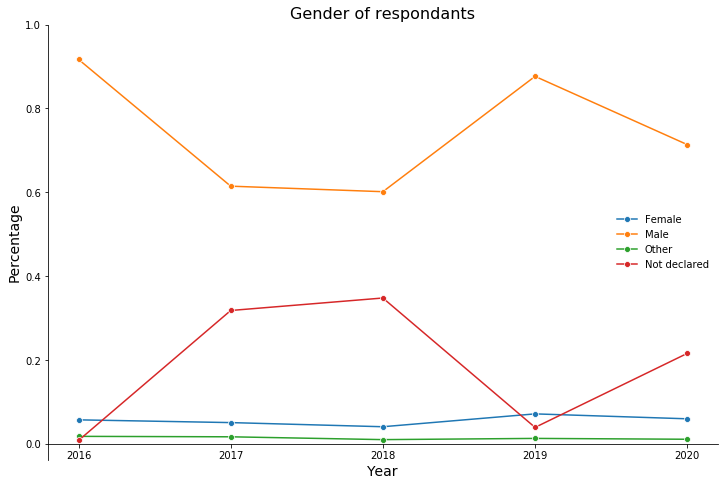

In [42]:
# Set figure size
plt.figure(figsize=(12,8))

# Define graph for each gender category
sns.lineplot(x = 'year', y = 'gender_female', data = df_gender, legend='brief', marker = 'o', label = 'Female')
sns.lineplot(x = 'year', y = 'gender_male', data = df_gender, legend='brief', marker = 'o', label = 'Male')
sns.lineplot(x = 'year', y = 'gender_other', data = df_gender, legend='brief', marker = 'o', label = 'Other')
sns.lineplot(x = 'year', y = 'gender_null', data = df_gender, legend='brief', marker = 'o', label = 'Not declared')

# Set details of plot
plt.title('Gender of respondants', fontsize = 16)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Percentage", fontsize = 14)
plt.xticks(df_gender['year'])
plt.yticks([0,.2,.4, .6, .8, 1])
plt.gca().spines['bottom'].set_position(('data',0))
plt.legend(loc = 'center right', frameon = False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot graph
plt.show();

I looks like women have constantly been under 10% of the respondant pool. It is worth noting, however, that many people choose to not declare their gender. We might want to look at what the composition of male, female and other are only among those people who chose to declare their gender.

In [43]:
# Define gender adjusted dataset
df_gender_adj = df_gender[['year', 'gender_male', 'gender_female', 'gender_other']]

# Set sum of relevat variables
sum_gender = df_gender_adj[['gender_male', 'gender_female', 'gender_other']].sum(axis=1)

# Adjust categories by only those who declared their gender
df_gender_adj['gender_male'] = df_gender_adj['gender_male']/sum_gender
df_gender_adj['gender_female'] = df_gender_adj['gender_female']/sum_gender
df_gender_adj['gender_other'] = df_gender_adj['gender_other']/sum_gender

# Print adjusted gender distributions
df_gender_adj.head()

,year,gender_male,gender_female,gender_other
0,2016,0.924477,0.057604,0.017918
1,2017,0.901332,0.074186,0.024481
2,2018,0.922273,0.062433,0.015294
3,2019,0.912336,0.074280,0.013383
4,2020,0.910121,0.076033,0.013846


With this in hands we can reproduce the graph we did before.

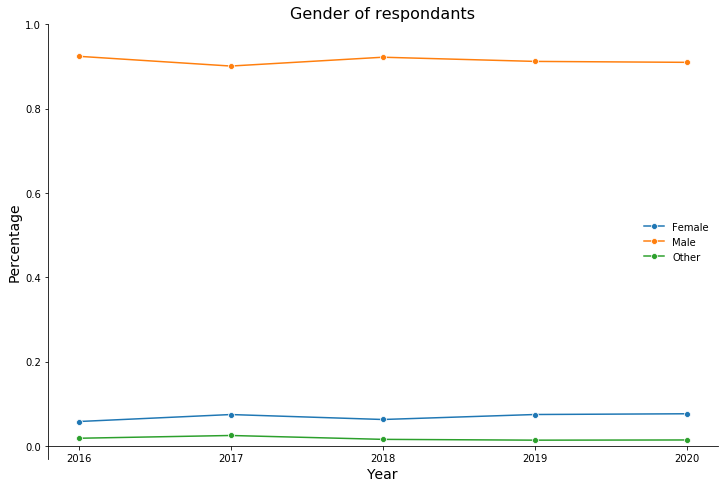

In [44]:
# Set figure size
plt.figure(figsize=(12,8))

# Define graph for each gender category
sns.lineplot(x = 'year', y = 'gender_female', data = df_gender_adj, legend='brief', marker = 'o', label = 'Female')
sns.lineplot(x = 'year', y = 'gender_male', data = df_gender_adj, legend='brief', marker = 'o', label = 'Male')
sns.lineplot(x = 'year', y = 'gender_other', data = df_gender_adj, legend='brief', marker = 'o', label = 'Other')

# Set details of plot
plt.title('Gender of respondants', fontsize = 16)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Percentage", fontsize = 14)
plt.xticks(df_gender['year'])
plt.yticks([0,.2,.4, .6, .8, 1])
plt.gca().spines['bottom'].set_position(('data',0))
plt.legend(loc = 'center right', frameon = False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot graph
plt.show();

This is no surprise as men did constitute the majority of respondants before. This exercise does indicate, however, that there is a lack of participation of women (and other gender identifications) in the Stack Overflow Annual Developer Survey, which could indicate a wider trend in the tech industry that needs to be addressed. Ideally we would want a higher participation of women in the tech industry.

### Are male respondants happier than female respondants?

Seeing that the majority of survey respondants are men, we could check if this translates into men having a higher job satisfaction than women and other gender identities.

In [45]:
score_jobsat = survey[['job_satisfaction', 'gender', 'year']].copy()

In [47]:
# Define function to assign satisfaction score
def satisfaction_score(value):
    '''This function takes a job satisfaction string and translates it
        into a score
    '''
    # Define score
    score = str(value).lower()
    # Score if very satisfied
    if score == 'very satisfied':
        output = 5
    # Score if satisfied
    elif score == 'satisfied':
        output = 4
    # Score if neither
    elif score == 'neither':
        output = 3
    # Score if dissatisfied
    elif score == 'dissatisfied':
        output = 2
    # Score if very dissatisfied
    elif score == 'very dissatisfied':
        output = 1
    else: # If value is null
        output = np.nan
    # Return desired output
    return(output)

# Create new variable and assign job satisfaction score
score_jobsat['satisfaction_score'] = score_jobsat['job_satisfaction'].parallel_apply(lambda x: satisfaction_score(x))

<Figure size 864x576 with 0 Axes>

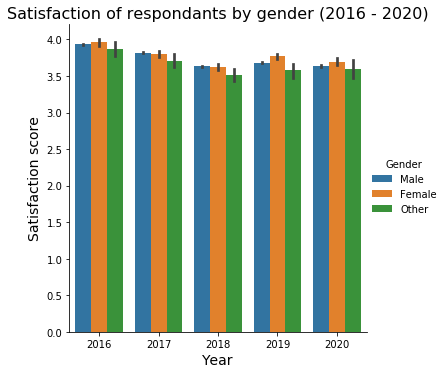

In [50]:
# Set figure size
plt.figure(figsize = (12,8))

# Define graph for satisfaction per gender over years
g = sns.catplot(x = 'year', y = 'satisfaction_score', hue = 'gender', kind= 'bar', data = score_jobsat)
g._legend.set_title("Gender")
# Set details of plot
plt.title('Satisfaction of respondants by gender (2016 - 2020)', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Satisfaction score', fontsize = 14);

It doesn't look like there is a significantly difference in job satisfaction over the years between genders. Note, however, that it does seem that happiness levels were slightly higher in 2016 if compared to the other years.

### What countries have the highest job satisfaction rates?

<a name="eval"></a>
## 5. Evaluate the results

Text text

<a name="deploy"></a>
## 6. Deploy

Text text

In [ ]:
os.getcwd()

In [ ]:
import geopandas as gpd

In [ ]:
map_df = gpd.read_file('IPUMSI_world_release2017/world_countries_2017.shp')

In [ ]:
ax = map_df.plot()
ax.axis('off');

In [ ]:
map_df.head()

In [ ]:
countries = map_df['CNTRY_NAME'].unique().tolist()

In [ ]:
'Bahamas' in countries

In [ ]:
countries2 = survey_2020['Country'].unique().tolist()

In [ ]:
import country_converter as coco

iso_lst1 = []
iso_lst2 = []

for country in countries:
    iso1 = coco.convert(names=country, to='ISO3')
    iso_lst1.append(iso1)

for country2 in countries2:
    iso2 = coco.convert(names=country2, to='ISO3')
    iso_lst2.append(iso2)


In [ ]:
for i in iso_lst2:
    print(i, i in iso_lst1)

In [ ]:
'US' in iso_lst1

In [ ]:
coco.convert(names='United States of America', to='ISO3')

In [ ]:
'USA' in iso_lst2

In [ ]:
for i in survey_2020.index:
    survey_2020.loc[i, 'Country'] = coco.convert(names = str(survey_2020.loc[i, 'Country']), to = 'ISO3')

In [ ]:
survey_2020.head()